In [1]:
from GmGM.synthetic import DatasetGenerator, PrecMatGenerator, PrecMatErdosRenyiGilbert
from GmGM import GmGM
from TeraLasso import TeraLasso
from EiGLasso import EiGLasso

import timeit
from statistics import median
import numpy as np
import matplotlib.pyplot as plt

In [2]:
linestyles = ['-', '--', '-.', ':']

In [3]:
def generate_timing_data_smart(
    algorithms: dict[str, callable],
    sizes: list[int],
    K: int,
    attempts: int, 
    cutoff: int = 60,
    verbose: bool = False
):  
    includes: dict[str, bool] = {}
    times: dict[str, list[float]] = {}
    
    for algorithm in algorithms:
        includes[algorithm]: bool = True
        times[algorithm]: list[float] = []
    for d in sizes:
        if not any(includes.values()):
            if verbose:
                print("All algorithms timed out")
            break
        if verbose:
            print(f"Starting {(d,) * K}")

        # Generate Data
        structure = {
            "dataset_0": tuple(f"axis_{j}" for j in range(K))
        }
        sub_generators = {
            f"axis_{i}": PrecMatGenerator(
                core_type="coreless",
                mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
            )
            for i in range(K)
        }
        generator = DatasetGenerator(
            structure=structure,
            generator=sub_generators,
            size={axis: d for axis in structure["dataset_0"]},
        )
        generator.reroll_Psis()
        dataset = generator.generate({"dataset_0": 1})

        # Test algorithms
        for algorithm in algorithms.keys():
            if not includes[algorithm]:
                continue
            times[algorithm].append(0)
            durations = timeit.Timer(
                lambda: algorithms[algorithm](dataset.deepcopy())
            ).repeat(
                repeat=attempts,
                number=1
            )
            times[algorithm][-1] = median(durations)
            if times[algorithm][-1] >= cutoff:
                if verbose:
                    print(f"{algorithm} ran for longer than {cutoff} seconds")
                    print(f"{algorithm} is no longer being tracked")
                includes[algorithm] = False
            else:
                if verbose:
                    print(f"\t{algorithm}: {times[algorithm][-1]} Seconds")
    print("Done")
    return times

## 2-Axis Runtimes

In [5]:
algorithms = {
    "GmGM": lambda dataset: GmGM(dataset, to_keep=10),
    "GmGM-50pc": lambda dataset: GmGM(dataset, to_keep=10, n_comps=50),
    "TeraLasso": lambda dataset: TeraLasso(dataset, 0),
    "EiGLasso": lambda dataset: EiGLasso(dataset, 0, 0),
}
size_data_2 = [
    # EiGLasso
    100, 125, 150, 175, 200, 225, 250, 275,
    # TeraLasso
    300, 400, 500,
    # GmGM
    600, 700, 800, 900, 1000,
    1100, 1200, 1300, 1400, 1500,
    1750, 2000, 2250, 2500,
    3000, 3500, 4000, 4500, 5000,
    # GmGM-50pc
    6000, 7000, 8000, 9000, 10000,
    11000
]
timing_data_2 = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data_2,
    K=2,
    attempts=1,
    verbose=True
)

Starting (100, 100)
	GmGM: 0.1008996249999825 Seconds
	GmGM-50pc: 1.0643862500000125 Seconds
	TeraLasso: 1.486650458000014 Seconds
	EiGLasso: 9.411201915999982 Seconds
Starting (125, 125)
	GmGM: 0.09207337500001245 Seconds
	GmGM-50pc: 0.28134733299998516 Seconds
	TeraLasso: 2.175221249999993 Seconds
	EiGLasso: 10.891935958000005 Seconds
Starting (150, 150)
	GmGM: 0.07014587500000857 Seconds
	GmGM-50pc: 0.3019859999999994 Seconds
	TeraLasso: 4.670125750000011 Seconds
	EiGLasso: 18.081388583999995 Seconds
Starting (175, 175)
	GmGM: 0.09777149999999324 Seconds
	GmGM-50pc: 0.3213966249999771 Seconds
	TeraLasso: 6.553122583000004 Seconds
	EiGLasso: 25.607922874999986 Seconds
Starting (200, 200)
	GmGM: 0.16116366700001095 Seconds
	GmGM-50pc: 0.3170765410000058 Seconds
	TeraLasso: 7.710871207999986 Seconds
	EiGLasso: 34.60930383300001 Seconds
Starting (225, 225)
	GmGM: 0.08842679200000703 Seconds
	GmGM-50pc: 0.35856674999996585 Seconds
	TeraLasso: 10.86641608299999 Seconds
	EiGLasso: 43.62930

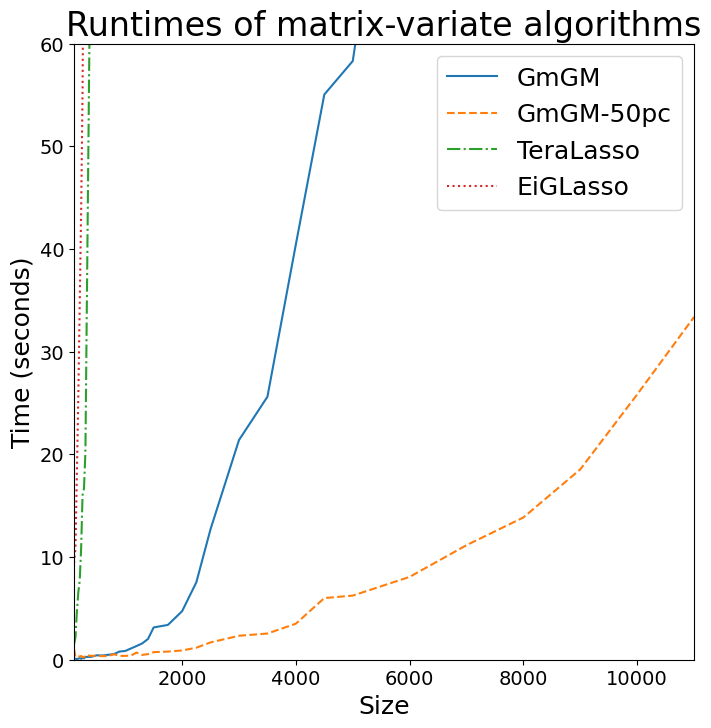

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_2):
    ax.plot(
        size_data_2[:len(timing_data_2[algorithm])],
        timing_data_2[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of matrix-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_2[0], size_data_2[-1]])
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_2.pdf", bbox_inches='tight')

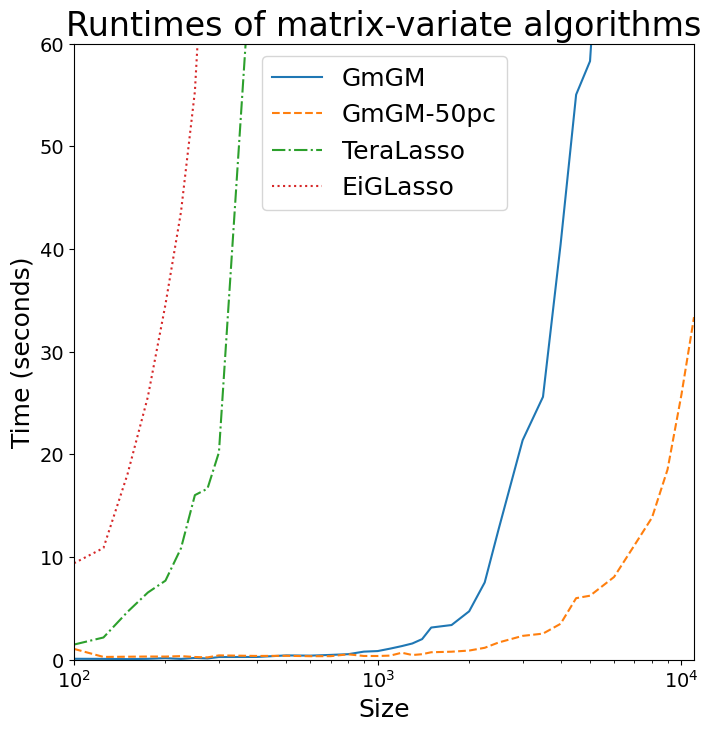

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_2):
    ax.plot(
        size_data_2[:len(timing_data_2[algorithm])],
        timing_data_2[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of matrix-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_2[0], size_data_2[-1]])
ax.set_xscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_2_log.pdf", bbox_inches='tight')

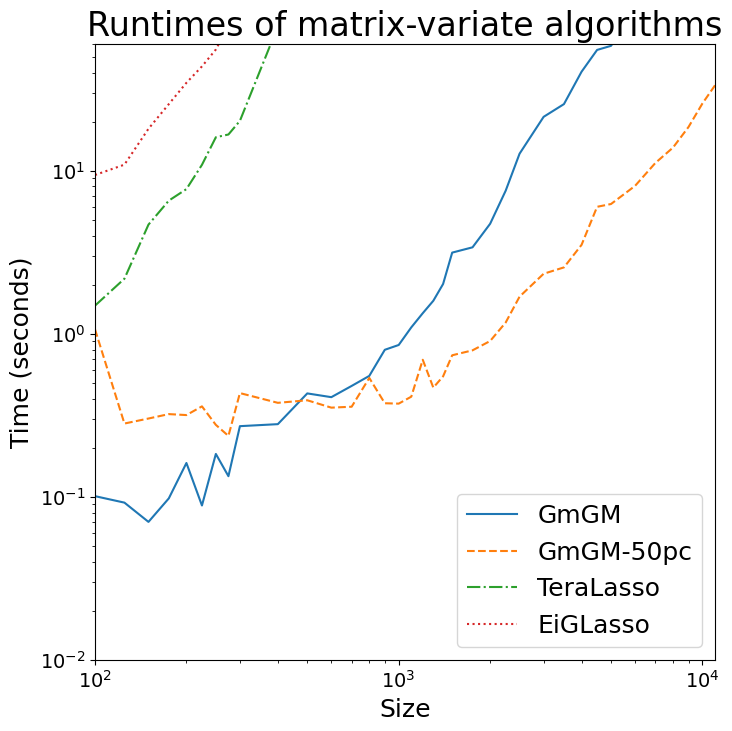

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_2):
    ax.plot(
        size_data_2[:len(timing_data_2[algorithm])],
        timing_data_2[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of matrix-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0.01, 60])
ax.set_xlim([size_data_2[0], size_data_2[-1]])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_2_loglog.pdf", bbox_inches='tight')

## 3-Axis Runtimes

In [9]:
algorithms = {
    "GmGM": lambda dataset: GmGM(dataset, to_keep=10),
    "GmGM-50pc": lambda dataset: GmGM(dataset, to_keep=10, n_comps=50),
    "TeraLasso": lambda dataset: TeraLasso(dataset, 0),
}
size_data_3 = [
    50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150,
    160, 170, 180, 190, 200, 250, 300, 350, 400, 450, 500
]
timing_data_3 = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data_3,
    K=3,
    attempts=1,
    verbose=True
)

Starting (50, 50, 50)
	GmGM: 1.085263292000036 Seconds
	GmGM-50pc: 0.46861908299979405 Seconds
	TeraLasso: 0.818703583000115 Seconds
Starting (60, 60, 60)
	GmGM: 0.215819625000222 Seconds
	GmGM-50pc: 0.47868654200010496 Seconds
	TeraLasso: 1.0128325410000798 Seconds
Starting (70, 70, 70)
	GmGM: 0.3799865830001181 Seconds
	GmGM-50pc: 0.5972727919997851 Seconds
	TeraLasso: 1.3740933750000295 Seconds
Starting (80, 80, 80)
	GmGM: 0.38396070899989354 Seconds
	GmGM-50pc: 0.8026790840003741 Seconds
	TeraLasso: 2.0148018330000923 Seconds
Starting (90, 90, 90)
	GmGM: 0.5071726670003045 Seconds
	GmGM-50pc: 0.8482563329998811 Seconds
	TeraLasso: 2.4264844170002107 Seconds
Starting (100, 100, 100)
	GmGM: 0.5241777090000141 Seconds
	GmGM-50pc: 1.0490416249999726 Seconds
	TeraLasso: 3.1911657919999925 Seconds
Starting (110, 110, 110)
	GmGM: 0.8357130419999521 Seconds
	GmGM-50pc: 3.4788487499999974 Seconds
	TeraLasso: 3.518642583000201 Seconds
Starting (120, 120, 120)
	GmGM: 1.0282177499998397 Second

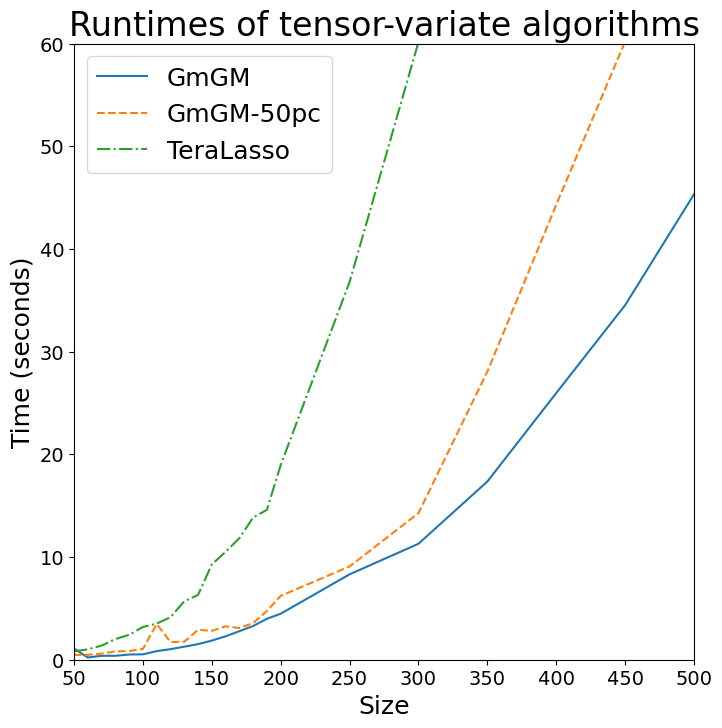

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_3):
    ax.plot(
        size_data_3[:len(timing_data_3[algorithm])],
        timing_data_3[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of tensor-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_3[0], size_data_3[-1]])
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_3.pdf", bbox_inches='tight')

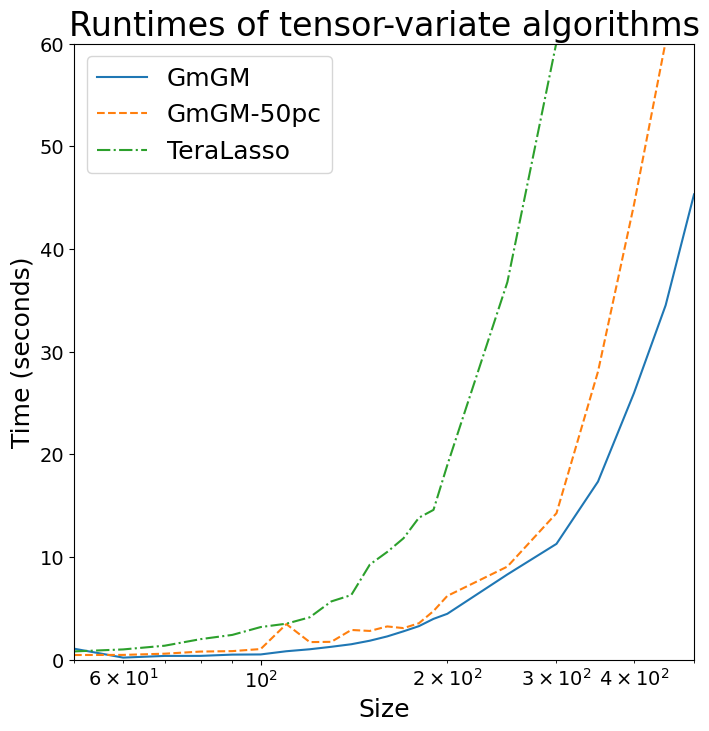

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_3):
    ax.plot(
        size_data_3[:len(timing_data_3[algorithm])],
        timing_data_3[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of tensor-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_3[0], size_data_3[-1]])
ax.set_xscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_3_log.pdf", bbox_inches='tight')

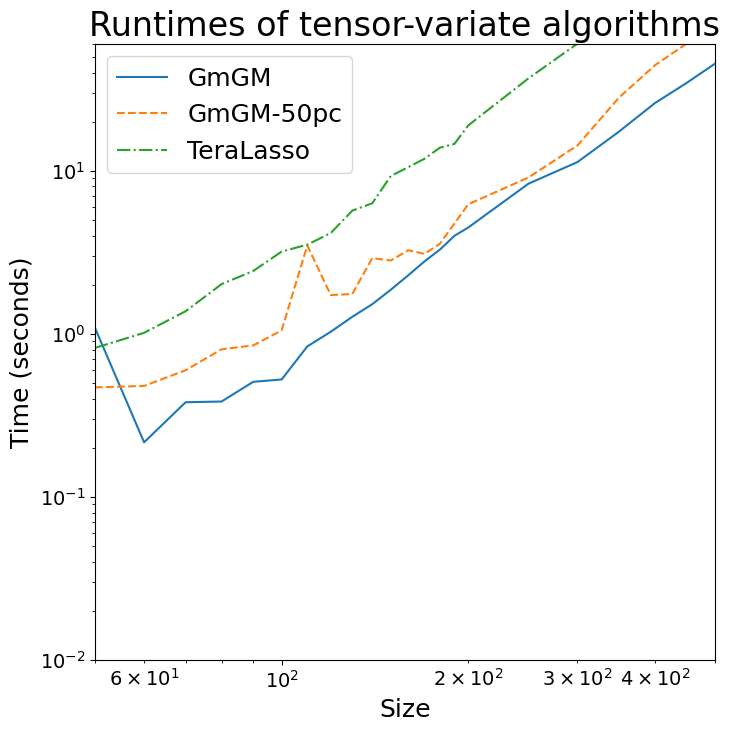

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_3):
    ax.plot(
        size_data_3[:len(timing_data_3[algorithm])],
        timing_data_3[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of tensor-variate algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0.01, 60])
ax.set_xlim([size_data_3[0], size_data_3[-1]])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_3_loglog.pdf", bbox_inches='tight')

## 4-Axis Runtimes

In [13]:
algorithms = {
    "GmGM": lambda dataset: GmGM(dataset, to_keep=10),
    "GmGM-50pc": lambda dataset: GmGM(dataset, to_keep=10, n_comps=50),
    "TeraLasso": lambda dataset: TeraLasso(dataset, 0),
}
size_data_4 = [
    20, 30, 40, 50, 60, 70, 80, 90, 100
]
timing_data_4 = generate_timing_data_smart(
    algorithms=algorithms,
    sizes=size_data_4,
    K=4,
    attempts=1,
    verbose=True
)

Starting (20, 20, 20, 20)
	GmGM: 0.7670751660002679 Seconds
	GmGM-50pc: 0.891286625000248 Seconds
	TeraLasso: 0.4990882080001029 Seconds
Starting (30, 30, 30, 30)
	GmGM: 0.8053919159997349 Seconds
	GmGM-50pc: 1.232238999999936 Seconds
	TeraLasso: 1.216086292 Seconds
Starting (40, 40, 40, 40)
	GmGM: 1.2919289169999502 Seconds
	GmGM-50pc: 3.59175816700008 Seconds
	TeraLasso: 3.907196749999912 Seconds
Starting (50, 50, 50, 50)
	GmGM: 0.8088127080000049 Seconds
	GmGM-50pc: 8.819264416999886 Seconds
	TeraLasso: 8.55373441599977 Seconds
Starting (60, 60, 60, 60)
	GmGM: 1.56848462500011 Seconds
	GmGM-50pc: 12.89990254200029 Seconds
	TeraLasso: 18.392063791000055 Seconds
Starting (70, 70, 70, 70)
	GmGM: 3.0033057499999813 Seconds
	GmGM-50pc: 32.376049707999755 Seconds
	TeraLasso: 46.55484050000041 Seconds
Starting (80, 80, 80, 80)
	GmGM: 5.045111625000118 Seconds


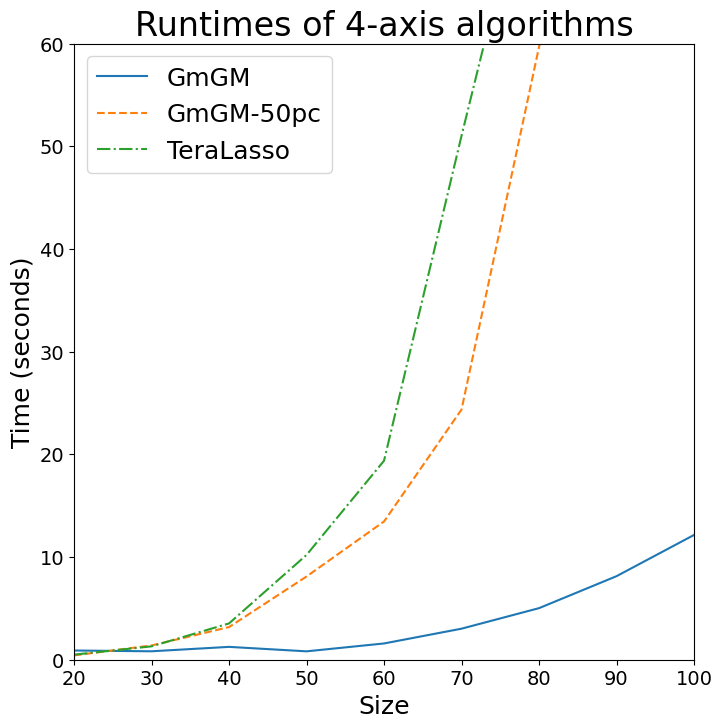

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_4):
    ax.plot(
        size_data_4[:len(timing_data_4[algorithm])],
        timing_data_4[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of 4-axis algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_4[0], size_data_4[-1]])
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_4.pdf", bbox_inches='tight')

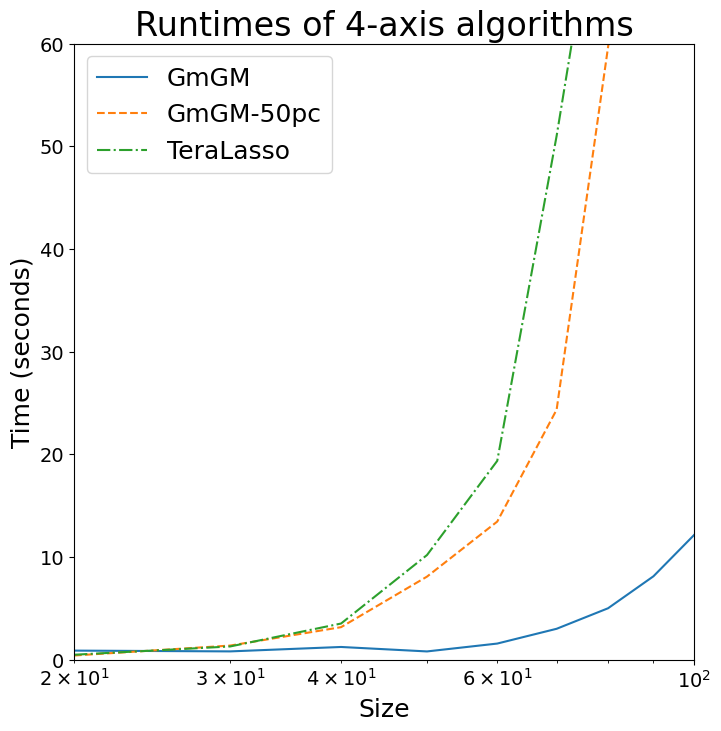

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_4):
    ax.plot(
        size_data_4[:len(timing_data_4[algorithm])],
        timing_data_4[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of 4-axis algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0, 60])
ax.set_xlim([size_data_4[0], size_data_4[-1]])
ax.set_xscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_4_log.pdf", bbox_inches='tight')

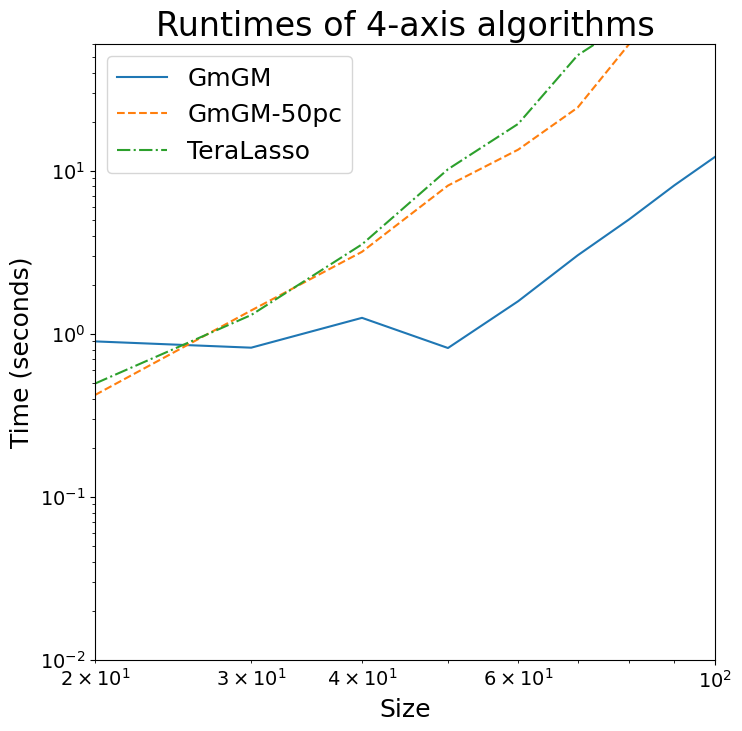

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
for idx, algorithm in enumerate(timing_data_4):
    ax.plot(
        size_data_4[:len(timing_data_4[algorithm])],
        timing_data_4[algorithm],
        label=algorithm,
        linestyle=linestyles[idx % len(linestyles)]
    )
ax.set_xlabel("Size", fontsize=18)
ax.set_ylabel("Time (seconds)", fontsize=18)
ax.set_title(f"Runtimes of 4-axis algorithms", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_ylim([0.01, 60])
ax.set_xlim([size_data_4[0], size_data_4[-1]])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=18)
fig.savefig("out_figs/runtimes_4_loglog.pdf", bbox_inches='tight')